In [28]:
# ===============================
# Convolutional Neural Network using Tensorflow using fit API
# Dataset: Cat and Dogs Recognition
# ===============================
from math import *
import matplotlib.pyplot as plt
import numpy as np
import h5py
from typing import List, Optional, Tuple
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from functools import partial
import optuna

In [29]:
def load_data(
    validation_ratio: float = 0.5,
    random_state: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Load training and test data from HDF5 files and split test set into validation and final test sets

    Parameters
    validation_ratio : float, optional (default=0.5)
        Fraction of the original test set to use as validation data
    random_state : int, optional (default=42)
        Random seed for reproducibility

    Returns
    X_train : np.ndarray
        Training features
    y_train : np.ndarray
        Training labels
    X_val : np.ndarray
        Validation features
    y_val : np.ndarray
        Validation labels
    X_test : np.ndarray
        Test features
    y_test : np.ndarray
        Test labels
    """
    # Load training data
    with h5py.File("../cat_dog_datasets/trainset.hdf5", "r") as train_dataset:
        X_train = np.array(train_dataset["X_train"][:])
        y_train = np.array(train_dataset["Y_train"][:])

    # Load test data
    with h5py.File("../cat_dog_datasets/testset.hdf5", "r") as test_dataset:
        X_test_full = np.array(test_dataset["X_test"][:])
        y_test_full = np.array(test_dataset["Y_test"][:])

    # Split test data into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(
        X_test_full,
        y_test_full,
        test_size=validation_ratio,
        random_state=random_state,
        stratify=y_test_full if len(np.unique(y_test_full)) > 1 else None
    )

    return X_train, y_train, X_val, y_val, X_test, y_test

In [30]:
# Define human-readable label names
label_names = {0: "Cat", 1: "Dog"}

def plot_images(
    X: np.ndarray,
    y: np.ndarray,
    y_pred: Optional[np.ndarray] = None,
    num_images: int = 10,
    img_shape: Tuple[int, int, int] = (64, 64, 1)
):
    """
    Plot flattened/normalized images with true and predicted labels
    
    Parameters:
    X : np.ndarray
        Flattened images (N, features)
    y : np.ndarray
        true labels (N, num_classes)
    y_pred : np.ndarray, optional
        predicted labels (N, num_classes)
    num_images : int, optional (default=10)
        Number of images to plot
    img_shape : Tuple[int, int, int]
        Original image shape (H, W, C)

    Returns:
    """
    # Convert one-hot to integer labels if needed
    if y.ndim > 1:
        y_int = np.argmax(y, axis=1)
    else:
        y_int = y

    # Dynamically compute grid size
    n_cols = min(5, num_images)  # max 5 images per row
    n_rows = ceil(num_images / n_cols)

    plt.figure(figsize=(4*n_cols, 4*n_rows))
    
    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i+1)
        
        # Reshape flattened image back to original shape
        img = X[i]
        # Handle grayscale (C=1) or color (C=3)
        if img.ndim == 3 and img.shape[-1] == 1:
            plt.imshow(img.squeeze(), cmap='gray')
        else:
            plt.imshow(np.clip(img, 0, 1))  # RGB image, ensure 0–1 range
        img = X[i].reshape(img_shape)
        
        # Title with True / Pred labels
        title = f"True: {label_names[y_int[i]]}"
        if y_pred is not None:
            title += f"\nPred: {label_names[y_pred[i]]}"
            
            # Optional: color title green/red for correct/incorrect
            color = 'green' if y_int[i] == y_pred[i] else 'red'
            plt.title(title, color=color, fontsize=10)
        else:
            plt.title(title, fontsize=10)
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Data loaded:
X_train shape: (1000, 64, 64, 1), y_train shape: (1000, 1)


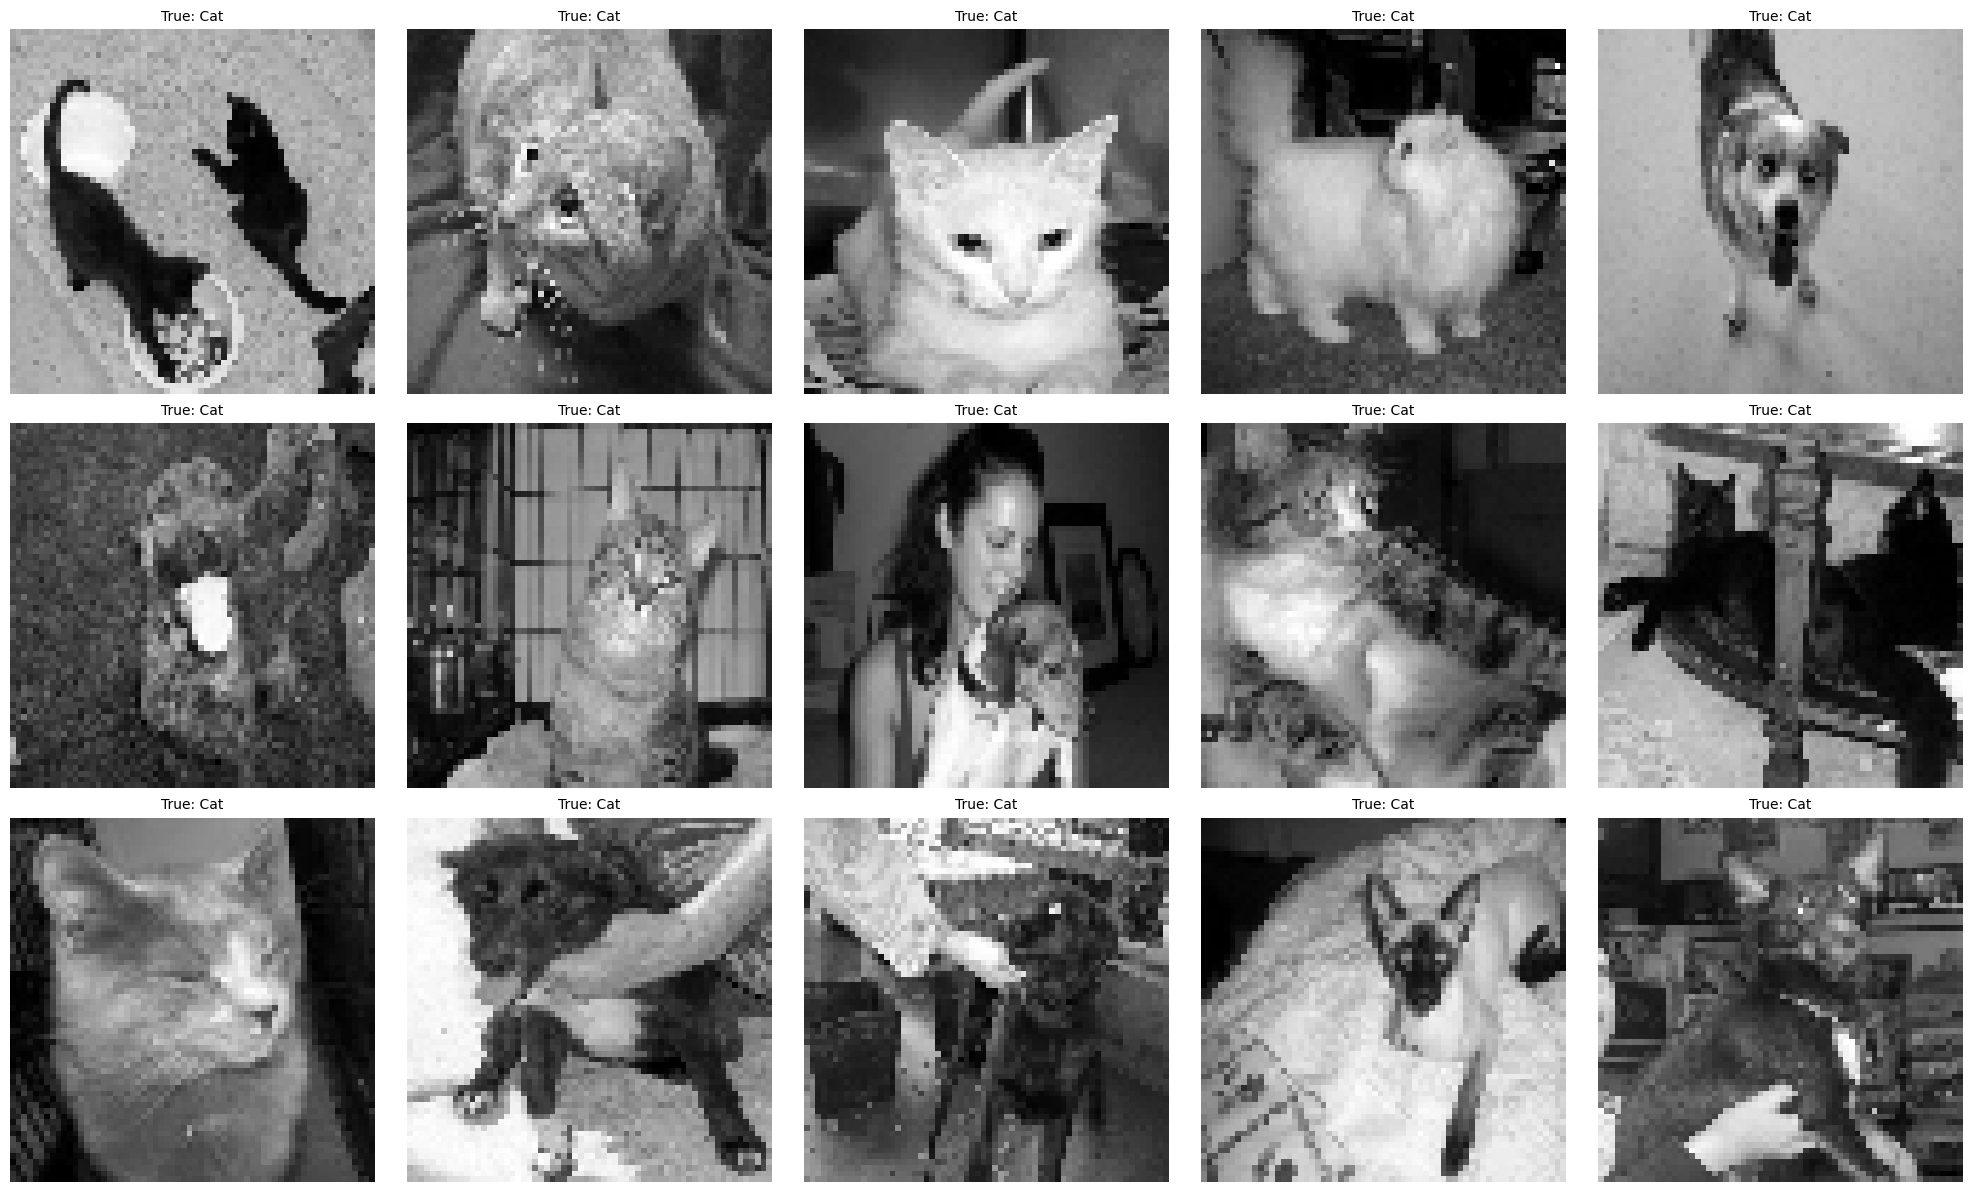

Augmented images:
X_train shape: (1000, 224, 224, 1), y_train shape: (1000, 1)


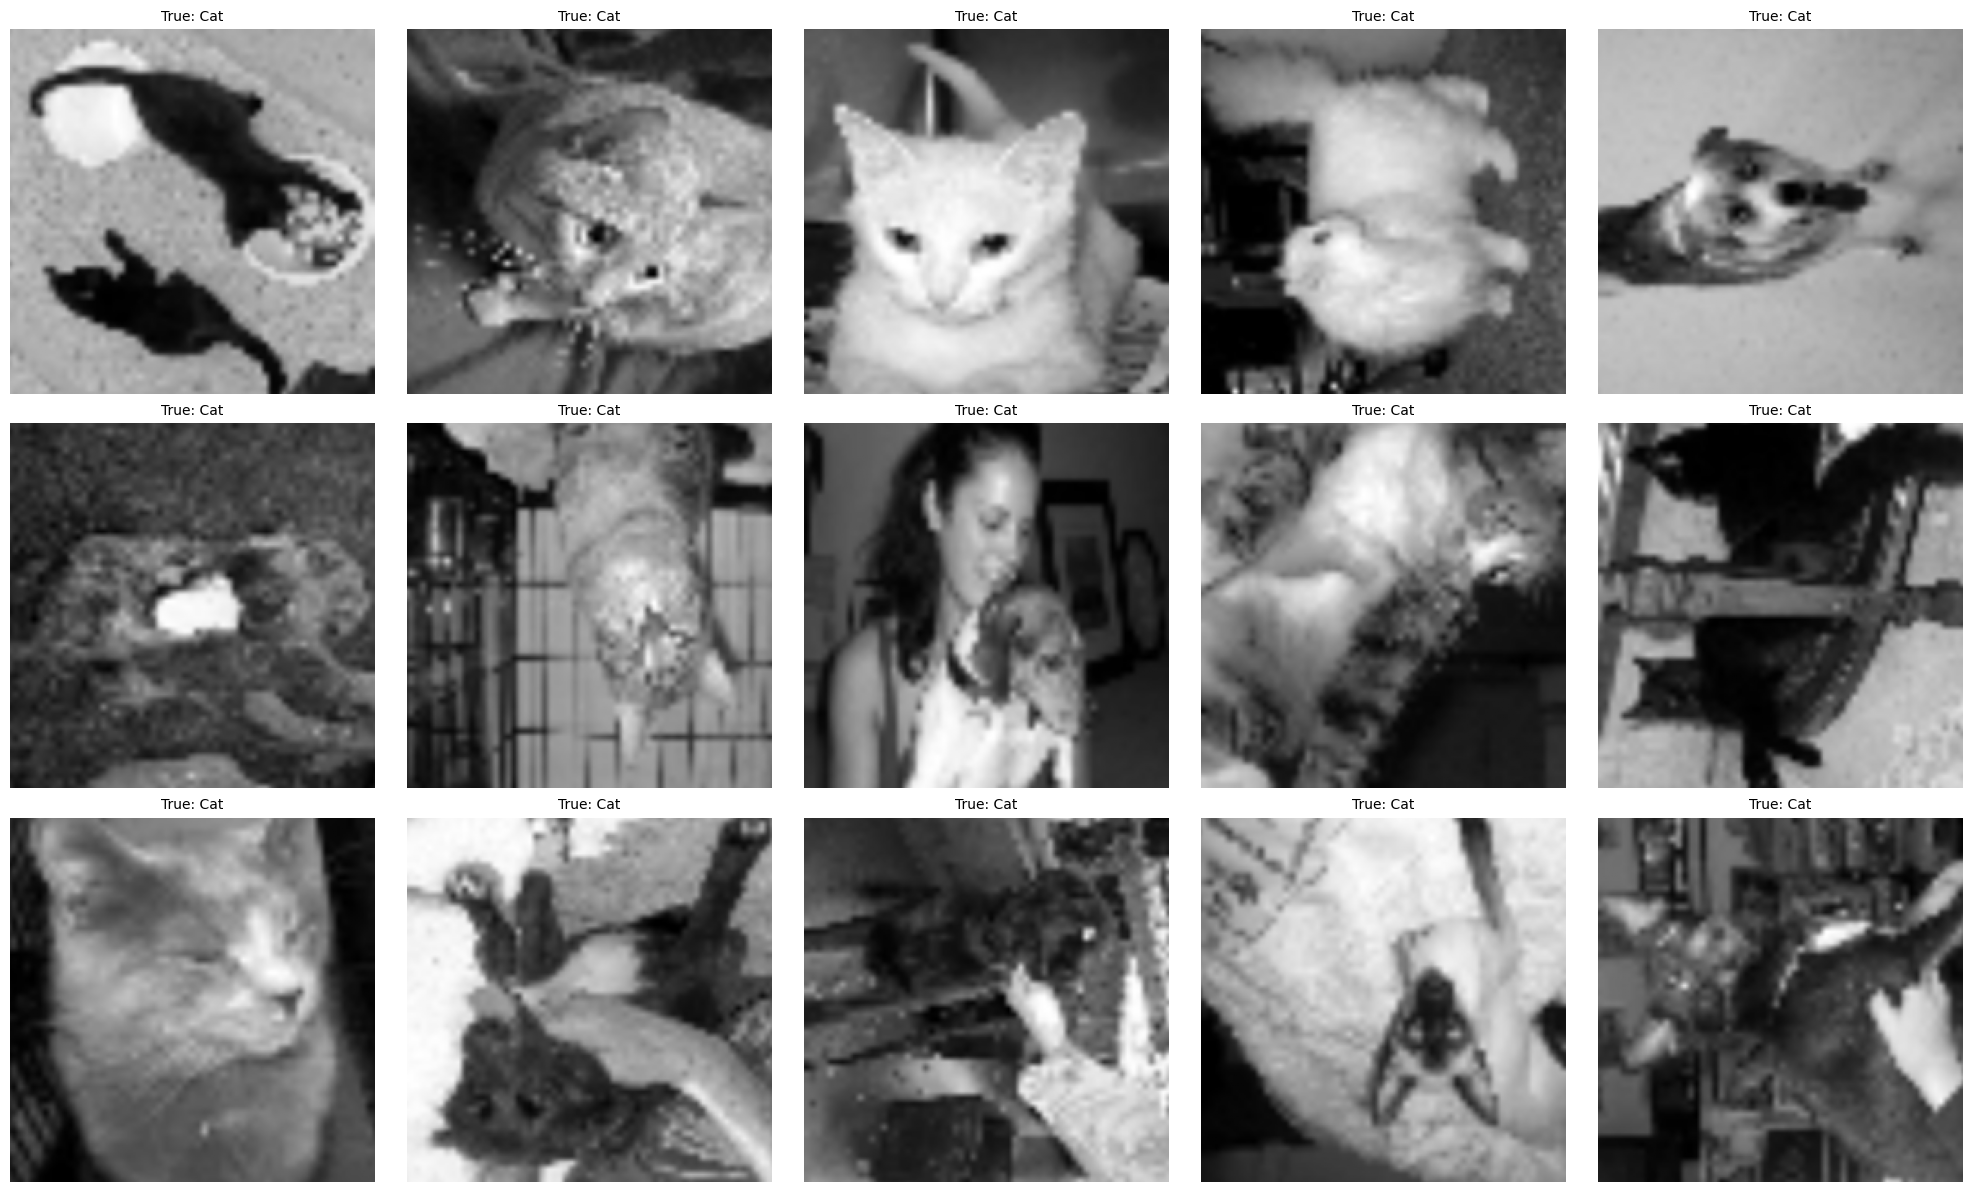

Preprocessing data...


/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Final shapes for model: X_train=(1000, 224, 224, 3), X_val=(100, 224, 224, 3), X_test=(100, 224, 224, 3)


In [31]:
plot_image = True
augment_by_hand = True
# =======================================
# 1. Load and Preprocess Data
# =======================================
X_train, y_train, X_val, y_val, X_test, y_test = load_data()
# Grayscale images (1 channel)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]
print("Data loaded:")
if plot_image:
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    plot_images(X_train, y_train, num_images=15, img_shape=(64, 64, 1))

# Resize to 224x224
def resize_to_224(image: np.ndarray) -> np.ndarray:
    image_resized = tf.image.resize(image, [224, 224]).numpy()
    return image_resized

X_train = np.array([resize_to_224(img) for img in X_train])
X_val = np.array([resize_to_224(img) for img in X_val])
X_test = np.array([resize_to_224(img) for img in X_test])

# Data Augmentation Function
def augment_image(
    image: tf.Tensor
) -> tf.Tensor:
    """
    Apply data augmentation to a single image tensor

    Parameters: 
    image : tf.Tensor
        Input image tensor of shape (H, W, C)
        
    Returns:
    tf.Tensor
        Augmented image tensor
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    crop_scale = tf.random.uniform([], 0.9, 1.0)
    crop_h = tf.cast(crop_scale * tf.cast(tf.shape(image)[0], tf.float32), tf.int32)
    crop_w = tf.cast(crop_scale * tf.cast(tf.shape(image)[1], tf.float32), tf.int32)
    image = tf.image.random_crop(image, size=[crop_h, crop_w, tf.shape(image)[-1]])
    image = tf.image.resize(image, (224, 224))
    
    return image

# Apply augmentation to the whole dataset
if augment_by_hand:
    X_train_aug = []
    for i in range(X_train.shape[0]):
        img = tf.convert_to_tensor(X_train[i], dtype=tf.float32)
        img_aug = augment_image(img)
        X_train_aug.append(img_aug.numpy())
    X_train = np.array(X_train_aug)
    print("Augmented images:")
    if plot_image:
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        plot_images(X_train, y_train, num_images=15, img_shape=(224, 224, 1))

# Normalize
print("Preprocessing data...")
X_train = X_train.astype("float32") / 255.0
X_val = X_val.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Label Encoding
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

output_dim = int(len(np.unique(y_train)))

# Convert grayscale to 3 channels for ResNet50
def gray_to_rgb(images: np.ndarray) -> np.ndarray:
    if images.shape[-1] == 1:
        return np.repeat(images, 3, axis=-1)
    return images

X_train = gray_to_rgb(X_train)
X_val = gray_to_rgb(X_val)
X_test = gray_to_rgb(X_test)

print(f"Final shapes for model: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")

In [32]:
# =======================================
# RNG setup 
RNG_SEED = 42
np.random.seed(RNG_SEED)
tf.random.set_seed(RNG_SEED)

In [33]:
# =======================================
# 2. Tensor Creation
# =======================================
def df_to_tf_dataset(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 64,
    shuffle: bool = True,
    augment_fn: Optional[callable] = None
) -> tf.data.Dataset:
    """
    Create a TensorFlow Dataset for image data (CNN-ready)

    Parameters
    ----------
    X : np.ndarray
        Image array of shape (N, H, W, C)
    y : np.ndarray
        Label array (one-hot or integer)
    batch_size : int
        Batch size for the dataset (default=64)
    shuffle : bool
        Whether to shuffle the dataset (default=True)
    augment_fn : callable, optional
        Function for on-the-fly data augmentation (e.g., augment_image)

    Returns
    -------
    tf.data.Dataset
        Optimized TensorFlow dataset ready for training
    """
    # Convert to tensor
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.int32)
    # Dataset from tuple (X, y)
    ds = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))
    # Shuffle if required
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=RNG_SEED)
    # Apply augmentation
    if augment_fn is not None:
        ds = ds.map(lambda x, y: (augment_fn(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [34]:
# Dataloaders
batch_size = 16
train_dataset = df_to_tf_dataset(X_train, y_train, batch_size=batch_size, shuffle=True, augment_fn=augment_image if augment_by_hand==False else None)
val_dataset = df_to_tf_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = df_to_tf_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

In [35]:
# =======================================
# 3. Prediction & Evaluation
# =======================================
def predict_tf(
    model: tf.keras.Model,
    ds:  tf.data.Dataset
) -> Tuple[np.ndarray, np.ndarray]: 
    """
    Predict classes and probabilities using the trained model

    Parameters:
    model : tf.keras.Model
        Trained model
    ds :  tf.data.Dataset,
        Tensorflow dataset for with image data

    Returns:
    np.ndarray
        Predicted class labels
    np.ndarray
        Predicted class probabilities
    """
    probs_list = [] 
    for X_batch, _ in ds:
        logits = model(X_batch, training=False) 
        probs = tf.nn.softmax(logits) 
        probs_list.append(probs) 
    probs = tf.concat(probs_list, axis=0) 
    preds = tf.argmax(probs, axis=1).numpy()
    return preds, probs.numpy()

def accuracy_score(
    y_true: np.ndarray,
    y_pred: np.ndarray
) -> float:
    """
    Compute accuracy score between true and predicted labels

    Parameters:
    y_true : np.ndarray
        True labels
    y_pred : np.ndarray
        Predicted labels

    Returns:
    float
        Accuracy percentage
    """
    return np.mean(y_true == y_pred) * 100

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 499ms/step - loss: 1.1798 - sparse_categorical_accuracy: 0.4976 - val_loss: 0.8025 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 468ms/step - loss: 1.0833 - sparse_categorical_accuracy: 0.5055 - val_loss: 0.6819 - val_sparse_categorical_accuracy: 0.5200
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 470ms/step - loss: 0.9421 - sparse_categorical_accuracy: 0.5701 - val_loss: 0.7194 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 31s 487ms/step - loss: 0.8910 - sparse_categorical_accuracy: 0.5822 - val_loss: 0.8046 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 470ms/step - loss: 0.7942 - sparse_categorical_accuracy: 0.6013 - val_loss: 0.7987 - val_sparse_categorical_accuracy: 0.5000
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 30s 472ms/step - loss: 0.7764 - sparse_categorical_accuracy: 0.6143 - val_loss: 0.7526 - val_sparse_categorical_accuracy: 0.520

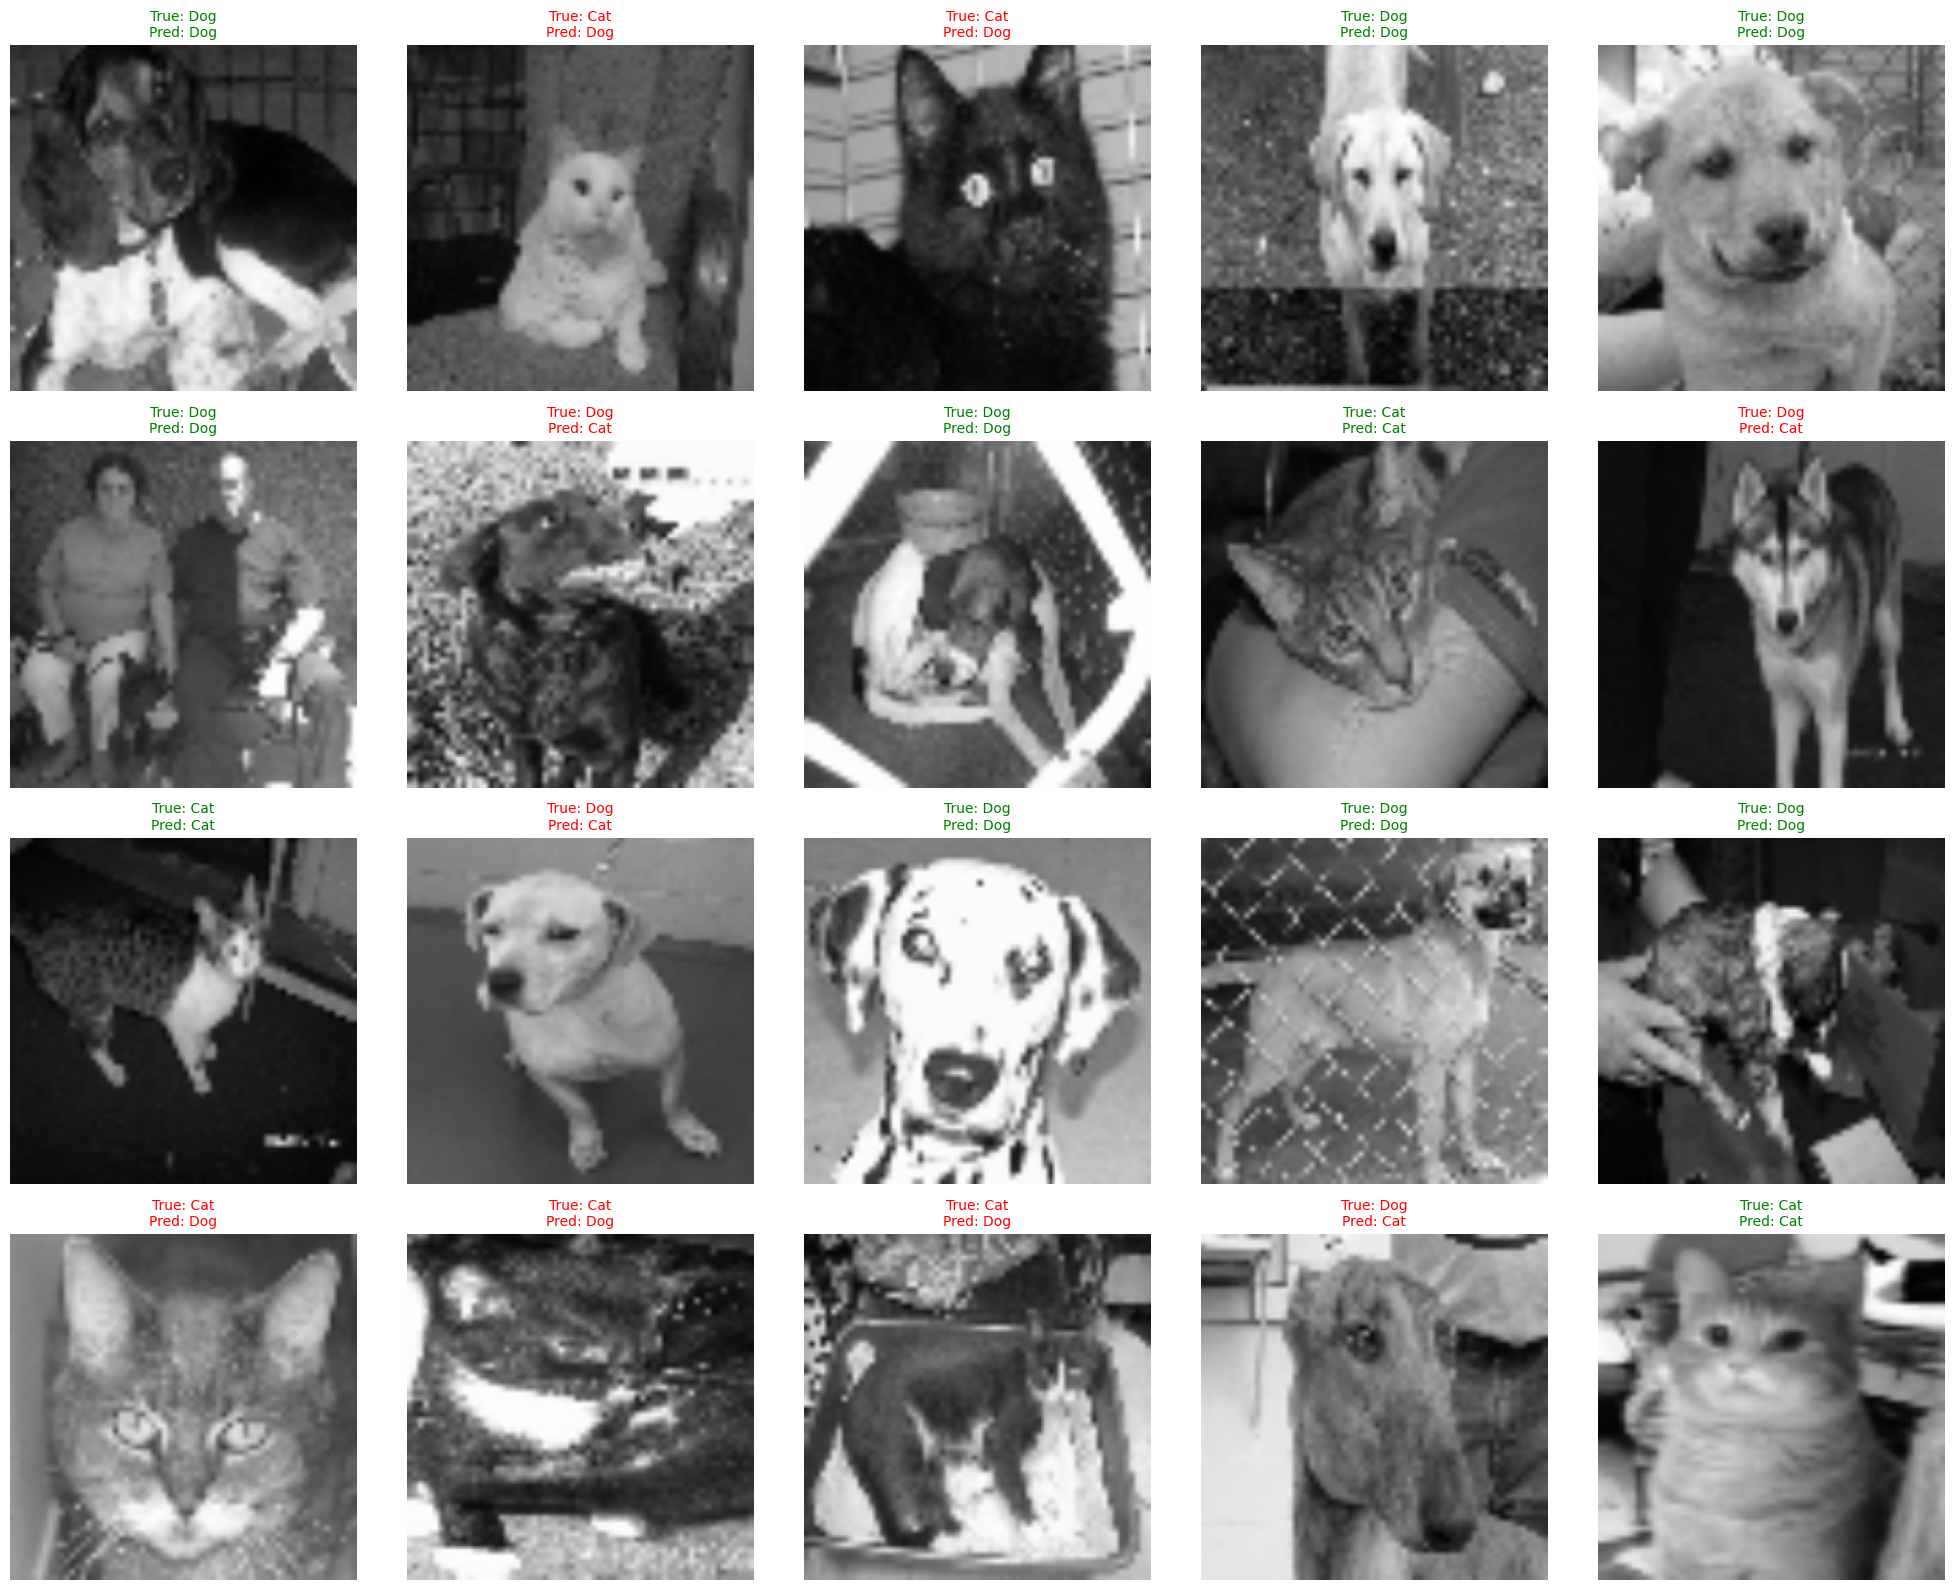

In [36]:
# =======================================
# 4. Load Pre-trained Model (ResNet50)
# =======================================
# ResNet50 already has:
# - Convolutional layers to extract low-level (edges, textures) and high-level features from images
# - BatchNorm + residual connections to stabilize training
# - Global pooling / fully connected layer at the top (optional) so this is usually the classification head trained on ImageNet classes
# - Already contains conv + dense layers, but we need more
base_model = tf.keras.applications.ResNet50(
    weights="imagenet",        # Load weights from ImageNet
    include_top=False,         # Exclude the final classification layer
    input_shape=(224, 224, 3)    # Must be 3 channels (RGB)
)
base_model.trainable = False   # Freeze for feature extraction

# =======================================
# 5. Build Custom Model
# =======================================
# Adding custom layers on top:
# - Tasks specific feature processing 
# - Let the network learn combinations of high-level features that are relevant to your new dataset
model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(output_dim, activation="softmax")
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(  # Learning rate scheduler
    initial_learning_rate=1e-4,
    decay_steps=10 * len(train_dataset),
    decay_rate=0.8, staircase=True
)
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=0.05),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# =======================================
# 6. Train the Model
# =======================================
history = model.fit(
    train_dataset, validation_data=val_dataset,
    epochs=10, verbose=1
)

# =======================================
# 7. Evaluate on test set
# =======================================
y_pred_test, _ = predict_tf(model, test_dataset)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.2f}%")
plot_images(X_test, y_test, y_pred_test, num_images=20, img_shape=(224, 224, 3))
# way too big model for this simple task


Data loaded:
Augmented images:
Preprocessing data...
Final shapes for model: X_train=(1000, 128, 128, 3), X_val=(100, 128, 128, 3), X_test=(100, 128, 128, 3)


/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 51ms/step - loss: 1.1661 - sparse_categorical_accuracy: 0.5117 - val_loss: 0.5969 - val_sparse_categorical_accuracy: 0.6700
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.9305 - sparse_categorical_accuracy: 0.5983 - val_loss: 0.4675 - val_sparse_categorical_accuracy: 0.7900
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.7842 - sparse_categorical_accuracy: 0.6695 - val_loss: 0.3971 - val_sparse_categorical_accuracy: 0.8000
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.7262 - sparse_categorical_accuracy: 0.6791 - val_loss: 0.3595 - val_sparse_categorical_accuracy: 0.8400
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - loss: 0.6760 - sparse_categorical_accuracy: 0.7116 - val_loss: 0.3418 - val_sparse_categorical_accuracy: 0.8500
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.5509 - sparse_categorical_accuracy: 0.7542 - val_loss: 0.3124 - val_sparse_categorical_accuracy: 0.8700
Epoch 7/10

2025-11-03 18:09:45.603091: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Test Accuracy: 80.00%


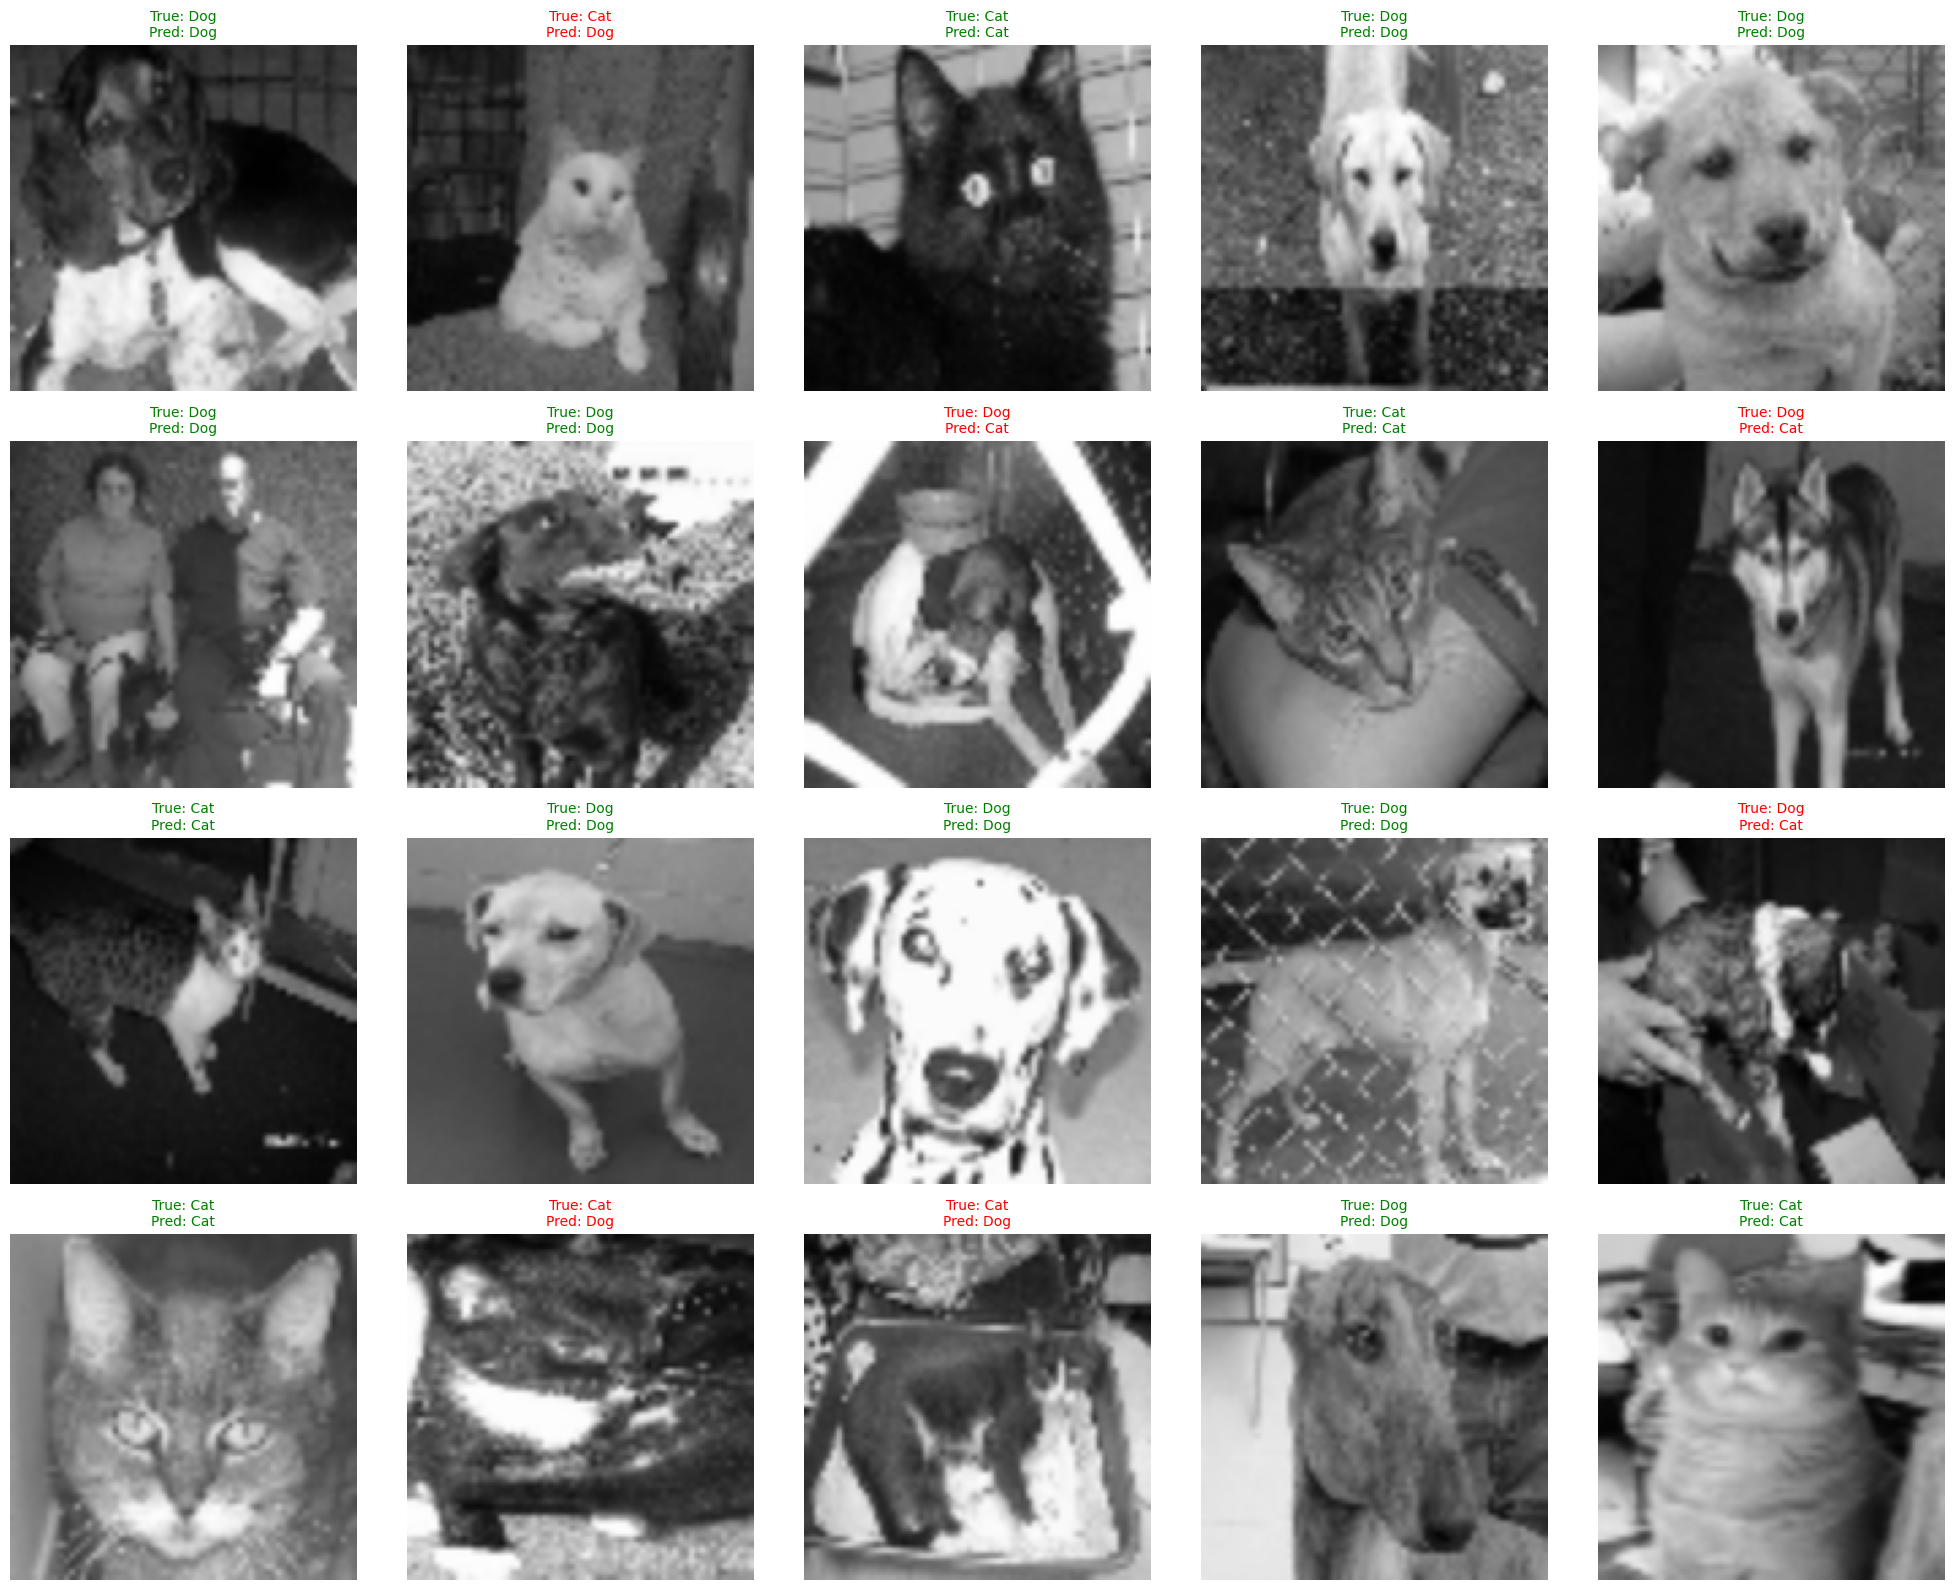

In [ ]:
from tensorflow.keras.applications import MobileNetV2

plot_image = False
augment_by_hand = True
# =======================================
# 1. Load and Preprocess Data
# =======================================
X_train, y_train, X_val, y_val, X_test, y_test = load_data()
# Grayscale images (1 channel)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]
print("Data loaded:")
if plot_image:
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    plot_images(X_train, y_train, num_images=15, img_shape=(64, 64, 1))

# Resize to 128x128
def resize_to_128(image: np.ndarray) -> np.ndarray:
    image_resized = tf.image.resize(image, [128, 128]).numpy()
    return image_resized

X_train = np.array([resize_to_128(img) for img in X_train])
X_val = np.array([resize_to_128(img) for img in X_val])
X_test = np.array([resize_to_128(img) for img in X_test])

# Data Augmentation Function
def augment_image(
    image: tf.Tensor
) -> tf.Tensor:
    """
    Apply data augmentation to a single image tensor

    Parameters: 
    image : tf.Tensor
        Input image tensor of shape (H, W, C)
        
    Returns:
    tf.Tensor
        Augmented image tensor
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    crop_scale = tf.random.uniform([], 0.9, 1.0)
    crop_h = tf.cast(crop_scale * tf.cast(tf.shape(image)[0], tf.float32), tf.int32)
    crop_w = tf.cast(crop_scale * tf.cast(tf.shape(image)[1], tf.float32), tf.int32)
    image = tf.image.random_crop(image, size=[crop_h, crop_w, tf.shape(image)[-1]])
    image = tf.image.resize(image, (128, 128))
    
    return image

# Apply augmentation to the whole dataset
if augment_by_hand:
    X_train_aug = []
    for i in range(X_train.shape[0]):
        img = tf.convert_to_tensor(X_train[i], dtype=tf.float32)
        img_aug = augment_image(img)
        X_train_aug.append(img_aug.numpy())
    X_train = np.array(X_train_aug)
    print("Augmented images:")
    if plot_image:
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        plot_images(X_train, y_train, num_images=15, img_shape=(128, 128, 1))

# Normalize
print("Preprocessing data...")
X_train = X_train.astype("float32") / 255.0
X_val = X_val.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Label Encoding
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

output_dim = int(len(np.unique(y_train)))

# Convert grayscale to 3 channels for ResNet50
def gray_to_rgb(images: np.ndarray) -> np.ndarray:
    if images.shape[-1] == 1:
        return np.repeat(images, 3, axis=-1)
    return images

X_train = gray_to_rgb(X_train)
X_val = gray_to_rgb(X_val)
X_test = gray_to_rgb(X_test)

print(f"Final shapes for model: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")

# Dataloaders
batch_size = 16
train_dataset = df_to_tf_dataset(X_train, y_train, batch_size=batch_size, shuffle=True, augment_fn=augment_image if augment_by_hand==False else None)
val_dataset = df_to_tf_dataset(X_val, y_val, batch_size=batch_size, shuffle=False)
test_dataset = df_to_tf_dataset(X_test, y_test, batch_size=batch_size, shuffle=False)

# =======================================
# 7. Fine-tune (optional but better than without)
# =======================================
base_model = MobileNetV2(
    input_shape=(128,128,3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

model = tf.keras.models.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(output_dim, activation='softmax')
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(  # Learning rate scheduler
    initial_learning_rate=1e-4,
    decay_steps=10 * len(train_dataset),
    decay_rate=0.8, staircase=True
)

model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=0.05),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

# Callbacks: EarlyStopping + ReduceLROnPlateau
callbacks_list = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]

# =======================================
# 6. Train the Model
# =======================================
history = model.fit(
    train_dataset, validation_data=val_dataset,
    callbacks=callbacks_list,
    epochs=10, verbose=1
)

# =======================================
# 7. Evaluate on test set
# =======================================
y_pred_test, _ = predict_tf(model, test_dataset)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.2f}%")
plot_images(X_test, y_test, y_pred_test, num_images=20, img_shape=(128, 128, 3))